# Rethinking Manpower Requirements Determination (Air Force Operations Research Symposium, March 2021)

<i>The following notebook contains the work, brief, and script for the AFORS 2021 conference presentation.  This presentation is unclassified and utilizes no real-world data to demonstrate the comparison of methods.</i>

## Introduction

Good afternoon, I am Zack Hornberger and I am a Force Support Officer currently serving as the Chief of Manpower Requirements Development at Headquarters Air Force, A1MR.  In personnel and manpower terminology, a <b>requirement</b> is a position in the workcenter that is needed to accomplish a mission.  For example, if your office has 10 people worth of work to perform, we would describe that as having 10 requirements.  My presentation today will briefly describe the deterministic process the Air Force currently uses to approximate manpower requirements and then will offer a new method, leveraging open source packages available in Python to combine simulation and optimization techniques to extract more information from the same data.

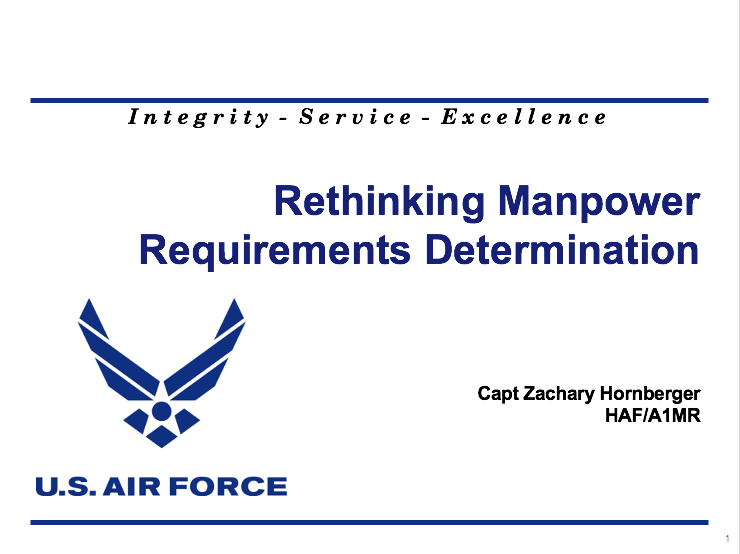

## Current Process

There are multiple ways that the manpower community has historically determined manpower, but the most common approach is depicted here.  First, the study team maps out all the processes that a workcenter performs and collects data on how long each task takes as well as how frequently each task is performed.  By multiplying task time by frequency, we can compute the total work of an office.  Dividing the total workload by the hours 1 person is available to work, we can compute the manpower for an individual office.  You can see the general formula for this depicted to the right.  Lastly, for Air Force wide studies, these individual workload levels are compared to characteristics of each location in an attempt to correlate manpower levels to external workload drivers.  The final product of a manpower study is a PDF document featuring a linear regression model and instructions for collecting information on the correlated workload drivers.  Ideally these workload drivers are strategic in nature, such as base population or assigned aircraft, but in reality they are sometimes too specific to have much predictive power, such as the number of meals served or reports filed.  There are a number of adverse considerations with this approach as noted on the slide, but the biggest one I will focus on throughout this presentation is the current inability to quantify risk or inform decisions related to manpower.

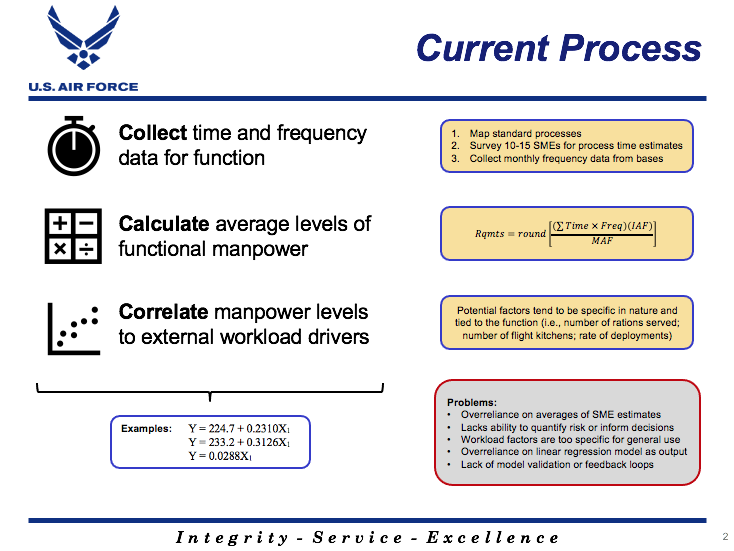

## Proposed Methodology

In contrast to our current methods for determining manpower, I will be discussing a proposed method which includes 8 key components compared to and including the 3 of the current process.  We will go more indepth on these components throughout the brief.

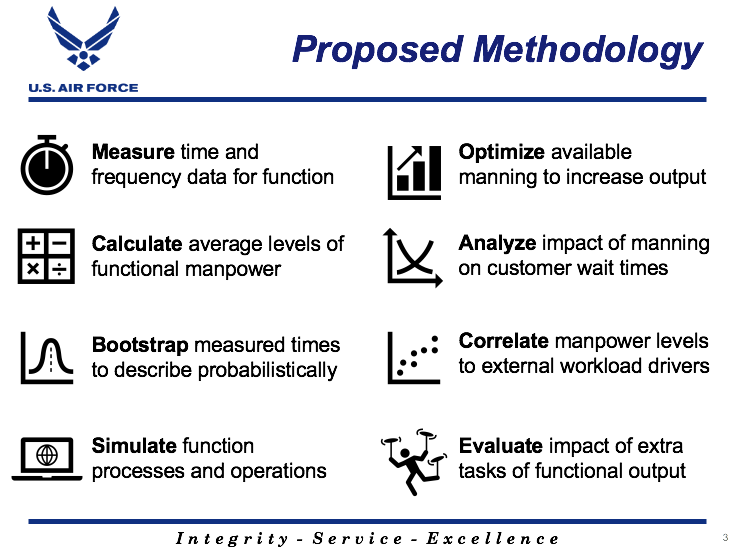

## Case Study

For demonstration purposes, I will use a toy example of a fictitious office called "Corporate Co" throughout this presentation.  In this scenario, the Corporate Co office is located at 80 locations and all offices perform 10 processes.  Half of these processes occur at fixed intervals - such as daily, weekly, or monthly intervals - and the other half occur as customers arrive to the office for support.

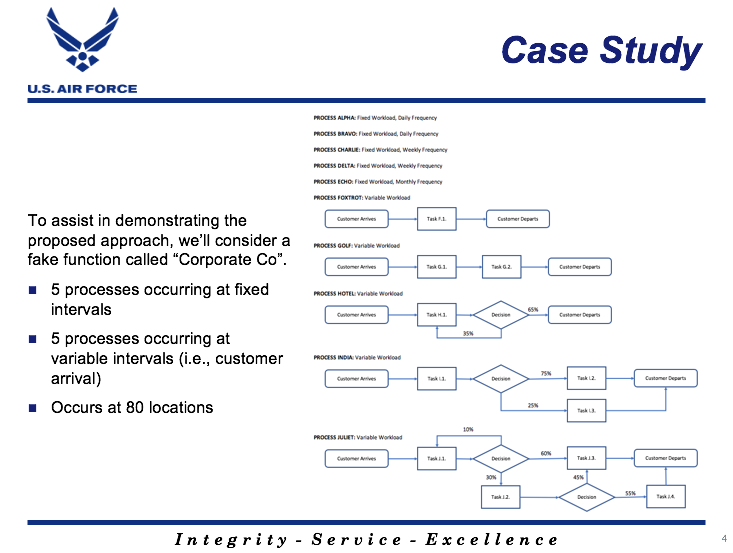

## Step 1: Measure

The first step of my proposed method is the same as that of the current method, with one key difference.  Currently, the time for processes is estimated by 10-12 subject matter experts to reach a single, average value.  Under my proposed method, we would select input locations and work with the local manpower offices at these locations to collect raw measurement data periodically over the course of a month.  By recognizing that human processes have inherent variability, we will be able to model that later in our method.

For the purposes of the case study, Corporate Co data was gathered via random number generations for each of the 10 processes and 80 locations.

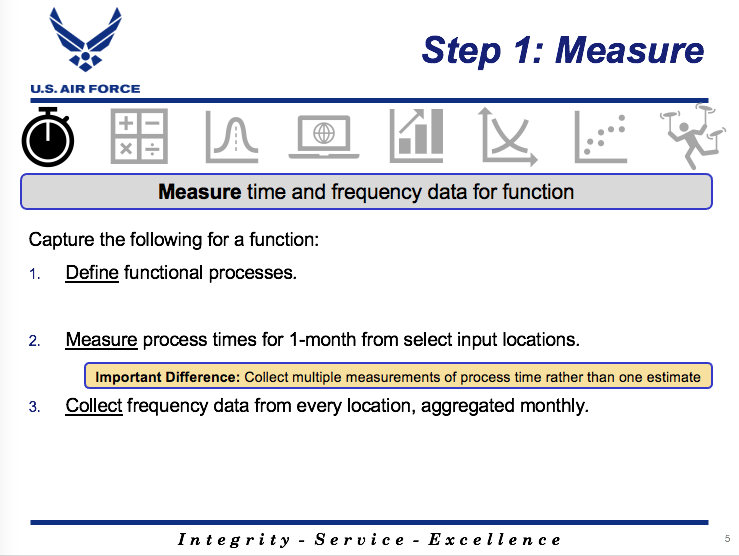

In [1]:
# Import packages needed throughout analysis
import random  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import simpy
import statistics
from scipy.optimize import curve_fit

# Initialization
random.seed(123)                         # Seed the random number generator
alpha_times = []                         # Initialize list for Process Alpha times
bravo_times = []                         # Initialize list for Process Bravo times
charlie_times = []                       # Initialize list for Process Charlie times
delta_times = []                         # Initialize list for Process Delta times
echo_times = []                          # Initialize list for Process Echo times
foxtrot_1_times = []                     # Initialize list for Task F.1. times
golf_1_times = []                        # Initialize list for Task G.1. times
golf_2_times = []                        # Initialize list for Task G.2. times
hotel_1_times = []                       # Initialize list for Task H.1. times
india_1_times = []                       # Initialize list for Task I.1. times
india_2_times = []                       # Initialize list for Task I.2. times
india_3_times = []                       # Initialize list for Task I.3. times
juliet_1_times = []                      # Initialize list for Task J.1. times
juliet_2_times = []                      # Initialize list for Task J.2. times
juliet_3_times = []                      # Initialize list for Task J.3. times
juliet_4_times = []                      # Initialize list for Task J.4. times
customer_data = []                       # Initialize customer data list

# Use random number generation to "collect" raw measurement time data
for i in range(360):                                # 30 daily measurements from 12 bases
    alpha_times.append(random.randint(35, 55))      # Process Alpha takes between 35 - 55 min
    bravo_times.append(random.randint(23, 47))      # Process Bravo takes between 23 - 47 min

for i in range(48):                                 # 4 weekly measurements from 12 bases
    charlie_times.append(random.randint(90, 130))   # Process Charlie takes between 90 - 130 min
    delta_times.append(random.randint(120, 130))    # Process Delta takes between 120 - 150 min
    
for i in range(12):                                 # 1 monthly measurement from 12 bases
    echo_times.append(random.randint(70, 95))       # Process Echo takes between 70-95 min

for i in range(600):                                # 50 task measurements from 12 bases
    foxtrot_1_times.append(random.randint(20, 40))  # Task F.1. takes between 20 - 40 min
    golf_1_times.append(random.randint(35, 50))     # Task G.1. takes between 35 - 50 min
    golf_2_times.append(random.randint(15, 27))     # Task G.2. takes between 15 - 27 min
    hotel_1_times.append(random.randint(30, 45))    # Task H.1. takes between 30 - 45 min
    india_1_times.append(random.randint(10, 18))    # Task I.1. takes between 10 - 18 min
    india_2_times.append(random.randint(5, 20))     # Task I.2. takes between 5 - 20 min
    india_3_times.append(random.randint(20, 37))    # Task I.3. takes between 20 - 37 min
    juliet_1_times.append(random.randint(15, 25))   # Task J.1. takes between 15 - 25 min
    juliet_2_times.append(random.randint(30, 50))   # Task J.2. takes between 30 - 50 min
    juliet_3_times.append(random.randint(25, 60))   # Task J.3. takes between 25 - 60 min
    juliet_4_times.append(random.randint(5, 25))    # Task J.4. takes between 5 - 25 min

# Compute the average process time ('Standard Activity Time') for each process
alpha_SAT = np.mean(alpha_times)
bravo_SAT = np.mean(bravo_times)
charlie_SAT = np.mean(charlie_times)
delta_SAT = np.mean(delta_times)
echo_SAT = np.mean(echo_times)
foxtrot_SAT = np.mean(foxtrot_1_times)
golf_SAT = np.mean(golf_1_times) + np.mean(golf_2_times)
hotel_SAT = np.mean(hotel_1_times) * 1.35
india_SAT = np.mean(india_1_times) + np.mean(india_2_times) * 0.75 + np.mean(india_3_times) * 0.25
juliet_SAT = np.mean(juliet_1_times) * 1.10 + np.mean(juliet_2_times) * 0.30 + np.mean(juliet_3_times) * (0.60 + 0.30 * 0.45) + np.mean(juliet_4_times) * (0.30 * 0.55)

# Use random number generation to "collect" customer frequency data
for base in range(1, 81):                                    # For each of the 80 locations
    foxtrot_cust = []                                        # Initialize foxtrot list
    golf_cust = []                                           # Initialize golf list
    hotel_cust = []                                          # Initialize hotel list
    india_cust = []                                          # Initialize india list
    juliet_cust = []                                         # Initialize juliet list
    F_lambda = random.randint(150, 270)                      # Randomly select foxtrot avg
    G_lambda = random.randint(230, 350)                      # Randomly select golf avg
    H_lambda = random.randint(50, 175)                       # Randomly select hotel avg
    I_lambda = random.randint(75, 215)                       # Randomly select india avg
    J_lambda = random.randint(200, 400)                      # Randomly select juliet avg

# Let's assume the monthly customer levels are normally distributed; this assumption would be evaluated in real-world
    for month in range(12):                                             # For each month in the year
        foxtrot_cust.append(np.random.normal(F_lambda, F_lambda/5))     # Determine number of foxtrot cust
        golf_cust.append(np.random.normal(G_lambda, G_lambda/5))        # Determine number of golf cust
        hotel_cust.append(np.random.normal(H_lambda, H_lambda/5))       # Determine number of hotel cust
        india_cust.append(np.random.normal(I_lambda, I_lambda/5))       # Determine number of india cust
        juliet_cust.append(np.random.normal(J_lambda, J_lambda/5))      # Determine number of juliet cust
    customer_data.append({'Base': f'Base {base}', 'Foxtrot': foxtrot_cust, 'Golf': golf_cust, 'Hotel': hotel_cust, 'India': india_cust, 'Juliet': juliet_cust})

# Store customer demand for each process/location in dataframe
customer_df = pd.DataFrame(customer_data).set_index('Base')  # Convert list of dict into df

## Step 2: Calculate

In the second step, the same procedure is utilized to compute location-specific levels of workload and subsequent manpower.  Whereas the current method ties the final manpower standard to the results of a linear regression model, my proposed method reports these values as the baseline requirement for each office and stores this information to serve as a reference point in future steps.

In our case study, we can compute relatively quickly the baseline requirements for Corporate Co offices at each of the 80 locations.  A subset of those results are displayed on the slide.

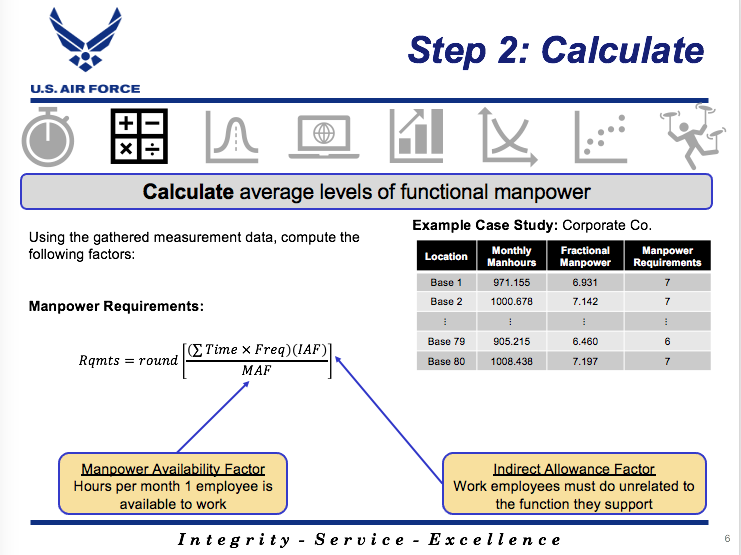

In [2]:
# Perform traditional computations to calculate the baseline manpower requirements
MMH_list = []                                                # Initialize the MMH list

for base in range(1, 81):                                    # For each of the 80 bases
    alpha_MMH = (alpha_SAT * 20.91) / 60                     # Convert daily process to MMH
    bravo_MMH = (bravo_SAT * 20.91) / 60                     # Convert daily process to MMH
    charlie_MMH = (charlie_SAT * 4.348) / 60                 # Convert weekly process to MMH
    delta_MMH = (delta_SAT * 4.348) / 60                     # Convert weekly process to MMH
    echo_MMH = (echo_SAT * 1.000) / 60                       # Convert monthly process to MMH
    
    # For customer-driven processes, multiply the SAT by the average monthly customers
    foxtrot_MMH = (foxtrot_SAT * np.mean(customer_df.loc[f'Base {base}']['Foxtrot'])) / 60
    golf_MMH = (golf_SAT * np.mean(customer_df.loc[f'Base {base}']['Golf'])) / 60
    hotel_MMH = (hotel_SAT * np.mean(customer_df.loc[f'Base {base}']['Hotel'])) / 60
    india_MMH = (india_SAT * np.mean(customer_df.loc[f'Base {base}']['India'])) / 60
    juliet_MMH = (juliet_SAT * np.mean(customer_df.loc[f'Base {base}']['Juliet'])) / 60
    MMH_list.append({'Base': f'Base {base}', 'MMH': alpha_MMH + bravo_MMH + charlie_MMH + delta_MMH + echo_MMH + foxtrot_MMH + golf_MMH + hotel_MMH + india_MMH + juliet_MMH})

OA_MMH_df = pd.DataFrame(MMH_list).set_index('Base')                 # Construct a dataframe of MMH, by base
IAF = 1.0619                                                         # Define indirect allowance factor
MAF = 148.79                                                         # Define the manpower availability factor
OA_MMH_df['Fractional Manpower'] = (OA_MMH_df['MMH'] * IAF) / MAF    # Compute Fractional Manpower
OA_MMH_df['Baseline Requirements'] = np.round(OA_MMH_df['Fractional Manpower'], 0)    # Round for baseline rqmts
OA_MMH_df.head()                                                     # Display subset of dataframe

,MMH,Fractional Manpower,Baseline Requirements
Base,,,
Base 1,940.133328,6.709642,7.0
Base 2,934.089598,6.666508,7.0
Base 3,945.255738,6.746200,7.0
Base 4,924.011617,6.594583,7.0
Base 5,996.557099,7.112333,7.0


## Step 3: Bootstrap

At the completion of step 2, we have the baseline manpower requirements each office, but we don't know how well that level of manning would prepare the office for real-world variability.  It is in these next steps that we harness the power of simulation to provide Commander's with insight into the risk associated with manpower.

Analyzing the raw measurement times gathered during our month of data collection, we may find that the process times can be described using a known probability distribution.  It is common, however, for that not to be the case.  In the instance of amorphously distributed time data, we can leverage bootstrapping and the Central Limit Theorem to effectively describe the mean time for every process as a normal distribution.  We would perform the same actions with respect to the monthly frequencies for each location, granting consideration to seasonal trends that may exist in the demand.

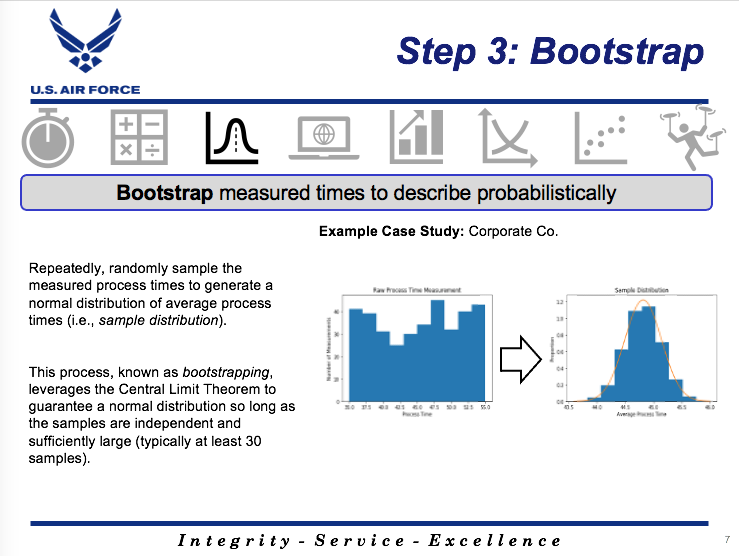

In [3]:
# The function bootstrap_replicate generates a 1-dimensional bootstrap replicate from a 1-dimensional array of data
# The function returns whatever operation is requested to be performed on the replicate, often np.mean
def bootstrap_replicate(data, func):
    replicate = np.random.choice(data, len(data))
    return func(replicate)

# The function draw_bs_reps takes a 1-dimensional array of data and generates 'size' number of replicates
# The function returns an array of data that is gathered from each bootstrap replicate, determined by...
# ...func (often np.mean)
def draw_bs_reps(data, func, size = 1000):
    #Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    
    #Generate 'size' number of replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate(data, func)
    
    return bs_replicates

# Run the above bootstrapping functions on each process/task generating sample mean distribution over 10,000 replicates
A = draw_bs_reps(alpha_times, np.mean, 10000)
B = draw_bs_reps(bravo_times, np.mean, 10000)
C = draw_bs_reps(charlie_times, np.mean, 10000)
D = draw_bs_reps(delta_times, np.mean, 10000)
E = draw_bs_reps(echo_times, np.mean, 10000)
F1 = draw_bs_reps(foxtrot_1_times, np.mean, 10000)
G1 = draw_bs_reps(golf_1_times, np.mean, 10000)
G2 = draw_bs_reps(golf_2_times, np.mean, 10000)
H1 = draw_bs_reps(hotel_1_times, np.mean, 10000)
I1 = draw_bs_reps(india_1_times, np.mean, 10000)
I2 = draw_bs_reps(india_2_times, np.mean, 10000)
I3 = draw_bs_reps(india_3_times, np.mean, 10000)
J1 = draw_bs_reps(juliet_1_times, np.mean, 10000)
J2 = draw_bs_reps(juliet_2_times, np.mean, 10000)
J3 = draw_bs_reps(juliet_3_times, np.mean, 10000)
J4 = draw_bs_reps(juliet_4_times, np.mean, 10000)

# Knowing that the bootstrapping functions will yield normally distributed process times, identify mean and std dev
alpha_mean, alpha_std = A.mean(), A.std()
bravo_mean, bravo_std = B.mean(), B.std()
charlie_mean, charlie_std = C.mean(), C.std()
delta_mean, delta_std = D.mean(), D.std()
echo_mean, echo_std = E.mean(), E.std()
foxtrot_mean, foxtrot_std = F1.mean(), F1.std()
golf_mean, golf_std = G1.mean() + G2.mean(), G1.std() + G2.std()
hotel_mean, hotel_std = H1.mean() * 1.35, H1.std() * 1.35
india_mean, india_std = I1.mean() + I2.mean() * 0.75 + I3.mean() * 0.25, I1.std() + I2.std() * 0.75 + I3.std() * 0.25
juliet_mean, juliet_std = J1.mean() * 1.10 + J2.mean() * 0.30 + J3.mean() * (0.60 + 0.30 * 0.45) + J4.mean() * (0.30 * 0.55), J1.std() * 1.10 + J2.std() * 0.30 + J3.std() * (0.60 + 0.30 * 0.45) + J4.std() * (0.30 * 0.55)

## Step 4: Simulate

We now have customer arrival rates and process durations described probabilistically for each office and can build a Monte Carlo simulator to replicate the variability we see in the real world.  To accomplish this, we can leverage the SimPy package in Python.  Using SimPy, a simulation for office operations can be built and the input variables of customer demand, number of employees, and process duration can be fed to the simulation.  The simulator can be used to assess a variety of metrics; two that I chose to examine for this case study are the rate at which every process is completed and how long customers had to wait for service.

In the case study of Corporate Co, I used SimPy to model office operations at each of the 80 bases over the course of 100 days for staffing levels ranging between 1 and 15 employees.  That is, we simulated the operations of Base 1 for 100 days with 1 employee, then 100 days with 2 employees, and so on for all locations and employee levels.

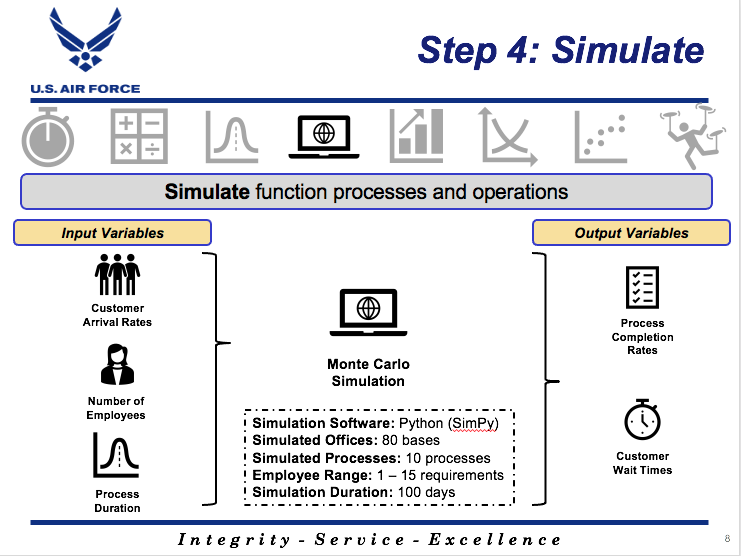

In [4]:
# Define the class 'CorporateCo' which houses functions for each process
# When a process is called, the simulator calls the particular process and adjusts the time...
# ...to reflect the process time as defined by our previously determined distributions.
class CorporateCo(object):
    # Set each team as attributes of service when the class is called
    def __init__(self, env, num_employee):
        self.env = env
        self.employee = simpy.Resource(env, num_employee)
        
    # Define functions for each process and set the process time
    def alpha(self, env, customer, day, wait):
        prcs_time = np.random.normal(alpha_mean, alpha_std)*IAF
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Alpha', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def bravo(self, env, customer, day, wait):
        prcs_time = np.random.normal(bravo_mean, bravo_std)*IAF                                      
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Bravo', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def charlie(self, env, customer, day, wait):
        prcs_time = np.random.normal(charlie_mean, charlie_std)*IAF         
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Charlie', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def delta(self, env, customer, day, wait):
        prcs_time = np.random.normal(delta_mean, delta_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Delta', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def echo(self, env, customer, day, wait):                                
        prcs_time = np.random.normal(echo_mean, echo_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Echo', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})

    def foxtrot(self, env, customer, day, wait):
        prcs_time = np.random.normal(foxtrot_mean, foxtrot_std)*IAF
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Foxtrot', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def golf(self, env, customer, day, wait):
        prcs_time = np.random.normal(golf_mean, golf_std)*IAF                                      
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Golf', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def hotel(self, env, customer, day, wait):
        prcs_time = np.random.normal(hotel_mean, hotel_std)*IAF         
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Hotel', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def india(self, env, customer, day, wait):
        prcs_time = np.random.normal(india_mean, india_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'India', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def juliet(self, env, customer, day, wait):                                
        prcs_time = np.random.normal(juliet_mean, juliet_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Juliet', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})


# Define the function visit_office to direct the actions of the customer once they arrive
def visit_office(env, customer, office, day, base):
    # Set arrival_time equal to the time this function starts (i.e., customer arrives)
    arrival_time = env.now
        
    # Draw a random number from 0 to 1
    rand_draw = random.random()
    
    # From the customer throughput data, compute the average number of customers for each process
    f_num = np.mean(customer_df.loc[base]['Foxtrot'])
    g_num = np.mean(customer_df.loc[base]['Golf'])
    h_num = np.mean(customer_df.loc[base]['Hotel'])
    i_num = np.mean(customer_df.loc[base]['India'])
    j_num = np.mean(customer_df.loc[base]['Juliet'])
    # Total the average number of customers for each process
    tot_num = (f_num + g_num + h_num + i_num + j_num)
    
    # Based on the random number and the probabilities of different services being requested...
    # ...customers will be funneled to the previously defined functions in class CorporateCo
    # Customers will request the service from a team member and wait until it is provided
    # Once a team member becomes available, the wait time will be calculated and stored
    if rand_draw <= f_num / tot_num:                                 
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.foxtrot(env, customer, day, wait))
    
    elif rand_draw <= (f_num + g_num) / tot_num:                               
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.golf(env, customer, day, wait))

    elif rand_draw <= (f_num + g_num + h_num) / tot_num:                               
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.hotel(env, customer, day, wait))
            
    elif rand_draw <= (f_num + g_num + h_num + i_num) / tot_num:                               
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.india(env, customer, day, wait))

    else:
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.juliet(env, customer, day, wait))
            
# Define the function visit_office_day to direct daily workload
def visit_office_daily(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.alpha(env, customer, day, wait))
        
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.bravo(env, customer, day, wait))
        
# Define the function visit_office_monthly to direct daily workload
def visit_office_weekly(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.charlie(env, customer, day, wait))
        
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.delta(env, customer, day, wait))

# Define the function visit_office_monthly to direct daily workload
def visit_office_monthly(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.echo(env, customer, day, wait))


# Define the function run_office which inputs the simulation's workforce, initializes the...
# ...customers waiting in the lobby when the office opens, and then periodically sends...
# ...customers into the office throughout the day.
def run_office(env, num_employee, day, base):
    office = CorporateCo(env, num_employee)
    customer = 1
    # Call daily workload
    env.process(visit_office_daily(env, customer, office, day))
    
    # Call weekly workload
    if day in np.arange(0, 300, 5):  
        env.process(visit_office_weekly(env, customer, office, day))
        
    if day in np.arange(0, 300, 21):  
        env.process(visit_office_monthly(env, customer, office, day))
    
    # From the customer throughput data, compute the average number of customers for each process
    f_num = np.mean(customer_df.loc[base]['Foxtrot'])
    g_num = np.mean(customer_df.loc[base]['Golf'])
    h_num = np.mean(customer_df.loc[base]['Hotel'])
    i_num = np.mean(customer_df.loc[base]['India'])
    j_num = np.mean(customer_df.loc[base]['Juliet'])
    # Based on total customers, draw from a normal distribution of the customers
    tot_num = math.ceil(np.random.normal((f_num + g_num + h_num + i_num + j_num) / 20.91, (f_num + g_num + h_num + i_num + j_num) / (5 * 20.91)))
    # Store the number the customers that arrived during the day
    tot_cust_arr.append(tot_num)
    
    # Evenly spaces the daily customers across the day and adds them to the simulation
    # While the number of customers is less than the total daily customers:
    i = 0
    while i < tot_num:
        yield env.timeout(np.random.exponential(((MAF / 20.91) * 60) / tot_num)) 
        i += 1
        customer += 1
        env.process(visit_office(env, customer, office, day, base))
        
# Define function calculate_wait_times to compute the average wait time at the each of the...
# ...simulation and convert it to a more readable format.
def average_wait_times(wait_times):
    average_wait = statistics.mean(wait_times)
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

def max_wait_times(wait_times):
    max_wait = np.max(wait_times)
    minutes, frac_minutes = divmod(max_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

# Define a function to general polynomial function to be fit to the curves
def func(x, a, b, c):
    return a * np.tanh(b * x) + c

# The function main serves as the core function which initiates the simulation and sets the...
# ...overarching parameters
def main(base, num_employee, num_days):
    # Seed the random number generators to make results reproducible 
    random.seed(42)
    np.random.seed(42)
    
    cust_start = []
    
    for day in range(num_days):        
        # Run simulation and set the duration (in minutes) for the simulation to run
        env = simpy.Environment()
        env.process(run_office(env, num_employee, day, base))
        env.run(until = (MAF / 20.91) * 60)                           

    # View the results
    mins, secs = average_wait_times(wait_times)
    mins_max, secs_max = max_wait_times(wait_times)
    
    # Convert the process roster into a dataframe and display
    process_roster = pd.DataFrame(roster)
    
    fixed_var = ['Alpha', 'Bravo', 'Charlie', 'Delta', 'Echo']
    a = process_roster[~process_roster.Process.isin(fixed_var)].groupby(['Day']).count()[['Process']]
    b = pd.DataFrame(tot_cust_arr)
    a = b.join(a, how = 'outer').rename(columns = {0: 'Customers Arrived', "Process": 'Customers Served'})
    a['Completion Rate'] = a['Customers Served'] / a['Customers Arrived']
    completion_rate = a['Completion Rate'].mean()
    completion_rate_min = np.percentile(a['Completion Rate'], 5)
    completion_rate_25 = np.percentile(a['Completion Rate'], 25)
    del process_roster
    return completion_rate

completion_rates = []

for location in OA_MMH_df.index.to_list():
    # Calls the main function to start the simulation
    # Collect the input variables
    base = location
    low_bound = 1
    high_bound = 15
    length = 100
    # Initialize arrays used to store outputs of each iteration of simulation run
    comp_rate_arr = []
    # Run the simulation for as many scenarios as requested by the user
    for i in range(low_bound, high_bound + 1):
        roster = []                                    # Initialize the transaction registry (used in sim)
        wait_times = []                                # Initialize the wait time array (used in sim)
        tot_cust_arr = []                              # Initialize the total customer array (used in sim)
        tot_cust_start = []
        b = main(base, i, length)          
        comp_rate_arr.append(b)
    # Define the x-axis to represent the number of employees working in the office for each scenario
    x = np.arange(low_bound, high_bound + 1)
    popt, pcov = curve_fit(func, x, comp_rate_arr)
    completion_rates.append(func(x, *popt))

table = pd.DataFrame(completion_rates)                  # Store completion rates in dataframe

In [5]:
# Store the table output to avoid having to rerun the above simulations
# Can reference output for future optimization efforts
store = pd.HDFStore('sim_output.h5')
store['table'] = table

## Step 5: Optimize

There are a few use cases that immediately come to mind as a manpower analyst once we have an effective simulation built.  The first is risk mitigation.  That is, although the manpower community may decide that a function requires a certain number of employees to accomplish the mission, we may not have enough money to fund all of those positions or people to fill those positions.  Therefore, it becomes advantageous to inform functional managers and manpower programmers where we should invest the limited funds we do have across the Air Force.

To this end, I've demonstrated a linear programming approach.  Utilizing the rate at which processes are completed as output from the simulation, we can build a linear programming model that seeks to allocate a constrained number of funded positions across all the bases in the Air Force in a manner that maximizes that customer throughput across the service.

To ensure the customer throughput at each location only increases as employees are added, but at a rate of diminishing returns, I elected to fit a hyperbolic tangent curve to the simulation outputs prior to converting it to cost variables for the linear program's objective function.

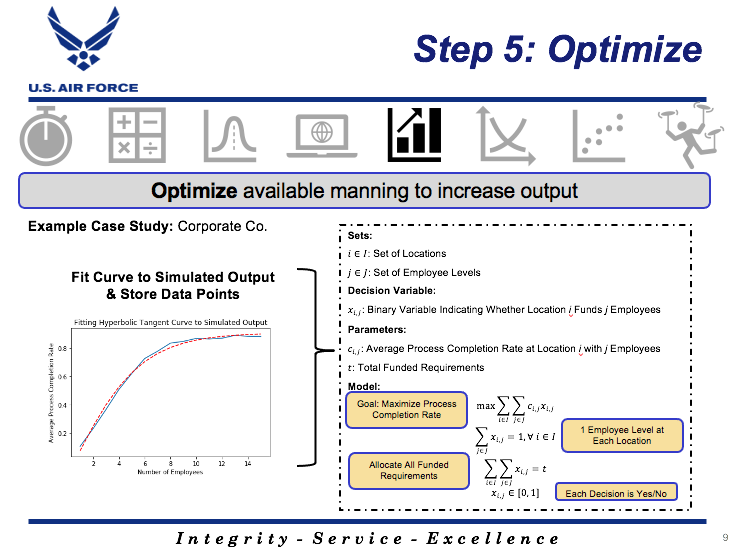

In the case of Corporate Co, the linear program was able to rapidly optimize the allocation of finite funded positions, known as <b>authorizations</b>, across all 80 locations in a manner that maximizes the total office throughput across the service.  For demonstration purposes, this was performed with authorization totals ranging between 391 and 791.

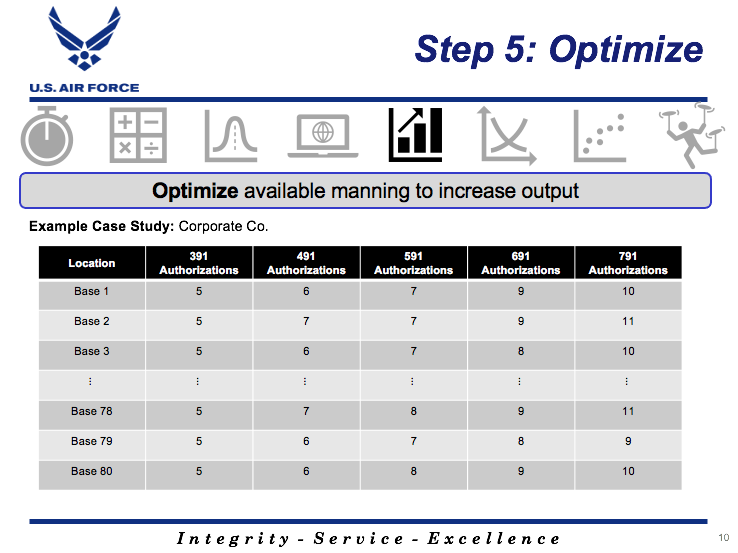

In [6]:
from pulp import LpMaximize, LpProblem, LpStatus, LpVariable

bases = OA_MMH_df.index.to_list()
nbr_employees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Total_Requirements = 591

model = LpProblem(name = 'Corporate Co', sense = LpMaximize)

combo = [(i, j) for i in bases for j in nbr_employees]

x = LpVariable.dicts('rqmts', (bases, nbr_employees), lowBound = 0, cat = 'Integer')

model += sum([table[nbr_employees.index(j)][bases.index(i)] * x[i][j] for (i, j) in combo])

for i in bases:
    model += (sum([x[i][j] for j in nbr_employees]) == 1, f'One Decision for Base {i}')
    
model += (sum([j * x[i][j] for (i, j) in combo]) == Total_Requirements, 'Set Total Requirements')

status = model.solve()

print(model.objective.value())
print(LpStatus[model.status])

for var in model.variables():
    if var.value() == 1.0:
        print(f'{var.name}: {var.value()}')



/opt/anaconda3/lib/python3.7/site-packages/pulp/pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


63.53528831659963
Optimal
rqmts_Base_10_8: 1.0
rqmts_Base_11_8: 1.0
rqmts_Base_12_8: 1.0
rqmts_Base_13_8: 1.0
rqmts_Base_14_7: 1.0
rqmts_Base_15_7: 1.0
rqmts_Base_16_6: 1.0
rqmts_Base_17_8: 1.0
rqmts_Base_18_8: 1.0
rqmts_Base_19_6: 1.0
rqmts_Base_1_7: 1.0
rqmts_Base_20_8: 1.0
rqmts_Base_21_7: 1.0
rqmts_Base_22_7: 1.0
rqmts_Base_23_7: 1.0
rqmts_Base_24_7: 1.0
rqmts_Base_25_8: 1.0
rqmts_Base_26_8: 1.0
rqmts_Base_27_7: 1.0
rqmts_Base_28_7: 1.0
rqmts_Base_29_7: 1.0
rqmts_Base_2_7: 1.0
rqmts_Base_30_7: 1.0
rqmts_Base_31_8: 1.0
rqmts_Base_32_7: 1.0
rqmts_Base_33_8: 1.0
rqmts_Base_34_7: 1.0
rqmts_Base_35_8: 1.0
rqmts_Base_36_8: 1.0
rqmts_Base_37_7: 1.0
rqmts_Base_38_7: 1.0
rqmts_Base_39_8: 1.0
rqmts_Base_3_7: 1.0
rqmts_Base_40_8: 1.0
rqmts_Base_41_7: 1.0
rqmts_Base_42_8: 1.0
rqmts_Base_43_7: 1.0
rqmts_Base_44_7: 1.0
rqmts_Base_45_7: 1.0
rqmts_Base_46_7: 1.0
rqmts_Base_47_7: 1.0
rqmts_Base_48_7: 1.0
rqmts_Base_49_8: 1.0
rqmts_Base_4_7: 1.0
rqmts_Base_50_7: 1.0
rqmts_Base_51_8: 1.0
rqmts_Base_5

## Step 6: Analyze

The other use case for the simulation that would be of interest is to determine how different staffing levels change wait time experienced by customers.  As demonstrated on the slide, we can use the simulation to plot changes in average and maximum customer wait time for a location under differing employment levels.  For reference, I've set the plot to display a dashed line at the manning level computed as our baseline requirements from Step 2.  This provides insight into how wait time can be improved or detrimented as we staff the office above or below that baseline threshold.

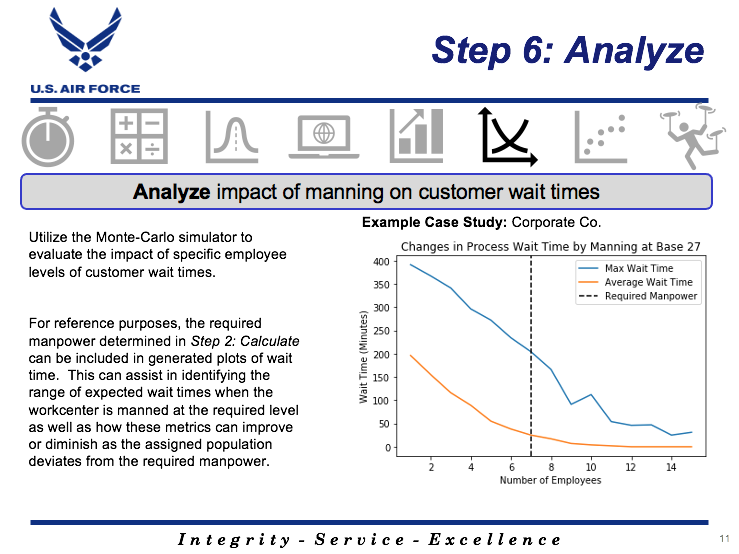

Which base would you like to simulate?  Base 27
What is the lowest number of employees you want to consider?  1
What is the highest number of employees you want to consider?  15
How many days would you like each simulation to run for?  100


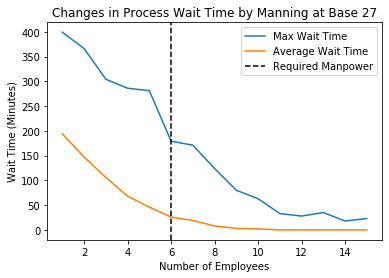

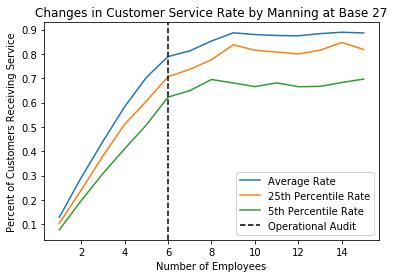

In [7]:
# Define the class 'CorporateCo' which houses functions for each process
# When a process is called, the simulator calls the particular process and adjusts the time...
# ...to reflect the process time as defined by our previously determined distributions.
class CorporateCo(object):
    # Set each team as attributes of service when the class is called
    def __init__(self, env, num_employee):
        self.env = env
        self.employee = simpy.Resource(env, num_employee)
        
    # Define functions for each process and set the process time
    def alpha(self, env, customer, day, wait):
        prcs_time = np.random.normal(alpha_mean, alpha_std)*IAF
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Alpha', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def bravo(self, env, customer, day, wait):
        prcs_time = np.random.normal(bravo_mean, bravo_std)*IAF                                      
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Bravo', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def charlie(self, env, customer, day, wait):
        prcs_time = np.random.normal(charlie_mean, charlie_std)*IAF         
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Charlie', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def delta(self, env, customer, day, wait):
        prcs_time = np.random.normal(delta_mean, delta_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Delta', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def echo(self, env, customer, day, wait):                                
        prcs_time = np.random.normal(echo_mean, echo_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Echo', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})

    def foxtrot(self, env, customer, day, wait):
        prcs_time = np.random.normal(foxtrot_mean, foxtrot_std)*IAF
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Foxtrot', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def golf(self, env, customer, day, wait):
        prcs_time = np.random.normal(golf_mean, golf_std)*IAF                                      
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Golf', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def hotel(self, env, customer, day, wait):
        prcs_time = np.random.normal(hotel_mean, hotel_std)*IAF         
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Hotel', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def india(self, env, customer, day, wait):
        prcs_time = np.random.normal(india_mean, india_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'India', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def juliet(self, env, customer, day, wait):                                
        prcs_time = np.random.normal(juliet_mean, juliet_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Juliet', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})


# Define the function visit_office to direct the actions of the customer once they arrive
def visit_office(env, customer, office, day, base):
    # Set arrival_time equal to the time this function starts (i.e., customer arrives)
    arrival_time = env.now
        
    # Draw a random number from 0 to 1
    rand_draw = random.random()
    
    # From the customer throughput data, compute the average number of customers for each process
    f_num = np.mean(customer_df.loc[base]['Foxtrot'])
    g_num = np.mean(customer_df.loc[base]['Golf'])
    h_num = np.mean(customer_df.loc[base]['Hotel'])
    i_num = np.mean(customer_df.loc[base]['India'])
    j_num = np.mean(customer_df.loc[base]['Juliet'])
    # Total the average number of customers for each process
    tot_num = (f_num + g_num + h_num + i_num + j_num)
    
    # Based on the random number and the probabilities of different services being requested...
    # ...customers will be funneled to the previously defined functions in class CorporateCo
    # Customers will request the service from a team member and wait until it is provided
    # Once a team member becomes available, the wait time will be calculated and stored
    if rand_draw <= f_num / tot_num:                                 
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.foxtrot(env, customer, day, wait))
    
    elif rand_draw <= (f_num + g_num) / tot_num:                               
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.golf(env, customer, day, wait))

    elif rand_draw <= (f_num + g_num + h_num) / tot_num:                               
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.hotel(env, customer, day, wait))
            
    elif rand_draw <= (f_num + g_num + h_num + i_num) / tot_num:                               
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.india(env, customer, day, wait))

    else:
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.juliet(env, customer, day, wait))
            
# Define the function visit_office_day to direct daily workload
def visit_office_daily(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.alpha(env, customer, day, wait))
        
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.bravo(env, customer, day, wait))
        
# Define the function visit_office_monthly to direct daily workload
def visit_office_weekly(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.charlie(env, customer, day, wait))
        
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.delta(env, customer, day, wait))

# Define the function visit_office_monthly to direct daily workload
def visit_office_monthly(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.echo(env, customer, day, wait))


# Define the function run_office which inputs the simulation's workforce, initializes the...
# ...customers waiting in the lobby when the office opens, and then periodically sends...
# ...customers into the office throughout the day.
def run_office(env, num_employee, day, base):
    office = CorporateCo(env, num_employee)
    customer = 1
    # Call daily workload
    env.process(visit_office_daily(env, customer, office, day))
    
    # Call weekly workload
    if day in np.arange(0, 300, 5):  
        env.process(visit_office_weekly(env, customer, office, day))
        
    if day in np.arange(0, 300, 21):  
        env.process(visit_office_monthly(env, customer, office, day))
    
    # From the customer throughput data, compute the average number of customers for each process
    f_num = np.mean(customer_df.loc[base]['Foxtrot'])
    g_num = np.mean(customer_df.loc[base]['Golf'])
    h_num = np.mean(customer_df.loc[base]['Hotel'])
    i_num = np.mean(customer_df.loc[base]['India'])
    j_num = np.mean(customer_df.loc[base]['Juliet'])
    # Based on total customers, draw from a normal distribution of the customers
    tot_num = math.ceil(np.random.normal((f_num + g_num + h_num + i_num + j_num) / 20.91, (f_num + g_num + h_num + i_num + j_num) / (5 * 20.91)))
    # Store the number the customers that arrived during the day
    tot_cust_arr.append(tot_num)
    
    # Evenly spaces the daily customers across the day and adds them to the simulation
    # While the number of customers is less than the total daily customers:
    i = 0
    while i < tot_num:
        yield env.timeout(np.random.exponential(((MAF / 20.91) * 60) / tot_num)) 
        i += 1
        customer += 1
        env.process(visit_office(env, customer, office, day, base))
        
# Define function calculate_wait_times to compute the average wait time at the each of the...
# ...simulation and convert it to a more readable format.
def average_wait_times(wait_times):
    average_wait = statistics.mean(wait_times)
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

def max_wait_times(wait_times):
    max_wait = np.max(wait_times)
    minutes, frac_minutes = divmod(max_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

# The function main serves as the core function which initiates the simulation and sets the...
# ...overarching parameters
def main(base, num_employee, num_days):
    # Seed the random number generators to make results reproducible 
    random.seed(42)
    np.random.seed(42)
    
    cust_start = []
    
    for day in range(num_days):        
        # Run simulation and set the duration (in minutes) for the simulation to run
        env = simpy.Environment()
        env.process(run_office(env, num_employee, day, base))
        env.run(until = (MAF / 20.91) * 60)                           

    # View the results
    mins, secs = average_wait_times(wait_times)
    mins_max, secs_max = max_wait_times(wait_times)
    
    # Convert the process roster into a dataframe and display
    process_roster = pd.DataFrame(roster)
    
    fixed_var = ['Alpha', 'Bravo', 'Charlie', 'Delta', 'Echo']
    a = process_roster[~process_roster.Process.isin(fixed_var)].groupby(['Day']).count()[['Process']]
    b = pd.DataFrame(tot_cust_arr)
    a = b.join(a, how = 'outer').rename(columns = {0: 'Customers Arrived', "Process": 'Customers Served'})
    a['Completion Rate'] = a['Customers Served'] / a['Customers Arrived']
    completion_rate = a['Completion Rate'].mean()
    completion_rate_min = np.percentile(a['Completion Rate'], 5)
    completion_rate_25 = np.percentile(a['Completion Rate'], 25)
    del process_roster
    return mins, completion_rate, completion_rate_min, completion_rate_25, mins_max

# Calls the main function to start the simulation
# Collect the input variables
base = input('Which base would you like to simulate?  ')
low_bound = int(input('What is the lowest number of employees you want to consider?  '))
high_bound = int(input('What is the highest number of employees you want to consider?  '))
length = int(input('How many days would you like each simulation to run for?  '))
# Initialize arrays used to store outputs of each iteration of simulation run
min_arr = []
max_min_arr = []
comp_rate_arr = []
comp_rate_min_arr = []
comp_rate_25_arr = []
# Run the simulation for as many scenarios as requested by the user
for i in range(low_bound, high_bound + 1):
    roster = []                                    # Initialize the transaction registry (used in sim)
    wait_times = []                                # Initialize the wait time array (used in sim)
    tot_cust_arr = []                              # Initialize the total customer array (used in sim)
    tot_cust_start = []
    a, b, c, d, e = main(base, i, length)          # Run simulation & store outputs in variables a - e
    min_arr.append(a)
    comp_rate_arr.append(b)
    comp_rate_min_arr.append(c)
    comp_rate_25_arr.append(d)
    max_min_arr.append(e)

# Define the x-axis to represent the number of employees working in the office for each scenario
x = np.arange(low_bound, high_bound + 1)

# Plot the wait time for each employee-based scenario
plt.plot(x, max_min_arr, label = 'Max Wait Time')
plt.plot(x, min_arr, label = 'Average Wait Time')
plt.axvline(x = np.round(OA_MMH_df.loc[base, 'Fractional Manpower'], 0), color = 'black', linestyle = '--', label = 'Required Manpower')
plt.xlabel('Number of Employees')
plt.ylabel('Wait Time (Minutes)')
plt.title(f'Changes in Process Wait Time by Manning at {base}')
plt.legend()
plt.show()

# Plot the % of customers to receive service for each employee-based scenario
plt.plot(x, comp_rate_arr, label = 'Average Rate')
plt.plot(x, comp_rate_25_arr, label = '25th Percentile Rate')
plt.plot(x, comp_rate_min_arr, label = '5th Percentile Rate')
plt.axvline(x = np.round(OA_MMH_df.loc[base, 'Fractional Manpower'], 0), color = 'black', linestyle = '--', label = 'Operational Audit')
plt.xlabel('Number of Employees')
plt.ylabel('Percent of Customers Receiving Service')
plt.title(f'Changes in Customer Service Rate by Manning at {base}')
plt.legend()
plt.show()

## Step 7: Correlate

Workload in an office is often influenced, directly or indirectly, by a number of external factors.  Some of these factors may be strategic, such as the base population or number of aircraft.  The ability to evaluate the degree to which a function's workload may be related to these such factors offers a number of potential benefits for manpower programmers.  However, as the manpower standard process under this proposed methodology no longer solely relies on a linear regression model, we have eliminated an adverse tendency for the manpower community to force a good fitting model by unintentionally overfitting the data or selecting hyperspecific factors that are not predictive in nature.

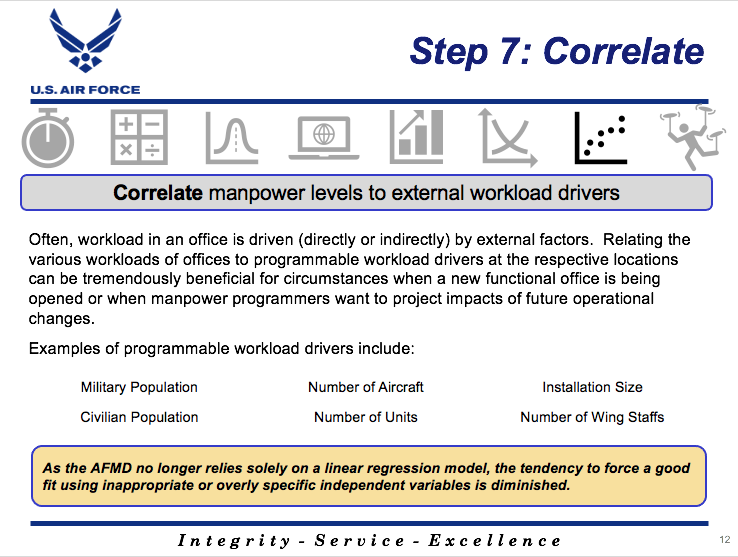

## Step 8: Evaluate

As it is advantageous for manpower programmers at headquarters to see how workload is influenced by strategic factors, it is also advantegous for unit commanders to see how various additional tasks may incur risk to the workcenter's operations.  Many of these additional processes - such as meetings, deployments, and TDYs - are intentionally not factored into the computed workload of an function but nonetheless impact a commander's ability to effectively accomplish the mission.  By leveraging our Monte Carlo simulation, we can add these additional activities and observe the risk that commanders are incurring in relation to staffing.

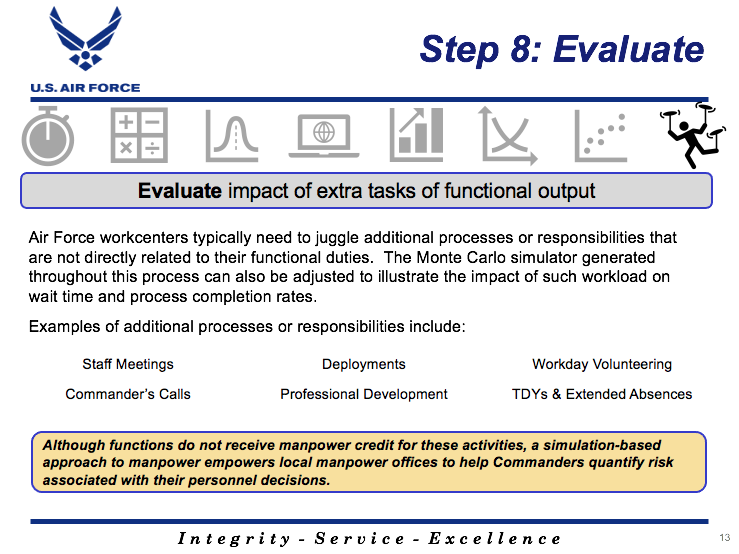

## Limitations, Considerations, and Areas of Further Research

Perhaps as evidenced by my use of a toy example throughout this presentation, this proposed methodology has yet to be tested in a real-world manpower study.  Perhaps the greatest hurdle to that occurring are current limitations in foundational understanding of Python, probability, and linear programming across the manpower enterprise.  Additionally, although there is a growing tendency to prefer information presented digitally, there is still hesitancy among many leaders regarding digital products that display any code.  Therefore, although my current work has been in the form of briefings to explain my concept and a Jupyter notebook to walkthough the code, I don't foresee widespread acceptance of such an approach until an attrative GUI or web-based interface is also constructed.

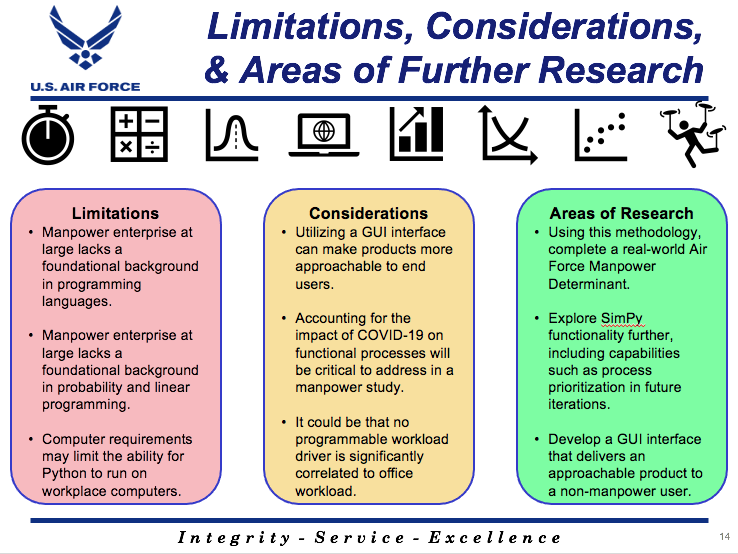

## Customer Benefits

I will conclude on this slide as it enumerates some of the benefits that can be gleaned from a simulation-based approach to manpower modeling.  There can often be disagreement across the manpower community as to who our customer is, and this proposed methodology acknowledges that there are many.  It attempts to provide actionable information regarding manpower allocation to functional communities, local commanders, local manpower offices, MAJCOM manpower offices, and headquarters programmers.

Thank you for attending my presentation today.  I will now open the floor for any questions.

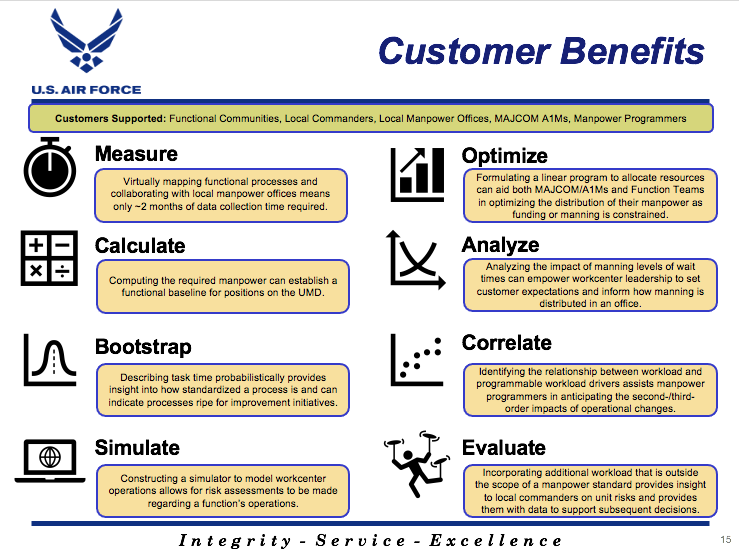